In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Installation
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Imports needed

import torch
from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torch import nn
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import torchvision.transforms as transforms

In [ ]:
# The minist database already exists in pytorch this is why we directly use MNIST with the needed parameters 
#exemple to transform images into tensors we pass if a transform parameter 
training_data = MNIST("mnist", 
                      train=True, 
                      download=True,
                      transform=transforms.Compose([
                             transforms.ToTensor(), # first, convert image to PyTorch tensor
                             transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                             ]))
testing_data = MNIST("mnist", train=False, download=True)

#loading the data
training_dl = DataLoader(training_data, batch_size=64, shuffle=True)

testing_dl = DataLoader(testing_data, batch_size=64)


In [ ]:
# Using Pytorch Lightning for the training
class ResNetMNIST(pl.LightningModule):
  def __init__(self):
    # Calling the pl.LightningModule constructor
    super().__init__()
    # Initiating a resnet with 10 classes for the MNIST database
    self.model = resnet18(num_classes=10)
    
    # Adapting the model to accepte a single channel (MNIST images are greyscale wich means one single channel)
    # The input layer originally accepts 3channels as we can see in the print:
    # (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    # Initiating the loss function
    self.loss = nn.CrossEntropyLoss()
    # Convert to a tensor 
    #self.transform = transforms.ToTensor()
    
  # Forward pass
  def forward (self, x):
    # Converting an image to a tensor
    #x = self.transform(x)
    #x = x.unsqueeze(0)  # add batch dimension
    return self.model(x)
  
  # Training step
  def training_step(self, batch, batch_no):
    # implement single training step
    x, y = batch
    # Calling self.forward
    logits = self(x)
    # Calculating the loss 
    loss = self.loss(logits, y)
    #print("loss", loss)
    return loss
  
  # Validation step
  def configure_optimizers(self):
    return torch.optim.RMSprop(self.parameters(), lr=0.005)


# Training the model
model = ResNetMNIST()
trainer = pl.Trainer(
    #gpus=1, # use one GPU
    max_epochs=1, # set number of epochs
    default_root_dir="/content/drive/MyDrive/models"
    #progress_bar_refresh_rate=20 # set to >= 20 if running in Google Colab
)
trainer.fit(model, training_dl)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 11.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


In [ ]:
# Saving the conv layer weights in this list
model_weights =[]
# Saving the conv layers in this list
conv_layers = []
# Get all the model children as list
model = model.model
model_children = list(model.children())
# Counter to keep count of the conv layers
counter = 0
# Append all the conv layers and their respective wights to the list
for i in range(len(model_children)):
    # Check for conv instance and add it to the list
    if type(model_children[i]) == nn.Conv2d:
        counter+=1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    # Also check for the ReLU instance and add it to the list
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter+=1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 17
conv_layers


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Image shape before: torch.Size([1, 238, 238])
Image shape after: torch.Size([1, 1, 238, 238])


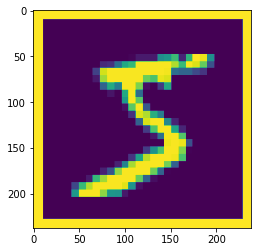

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# reading the image (put the name of any minist image)
image = Image.open(str('MNIST_6_0.png')).convert('L')
plt.imshow(image)

# transformations
transform=transforms.Compose([
                             transforms.ToTensor(), # first, convert image to PyTorch tensor
                             transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                             ])
# applying the transformation to the image
image = transform(image)
print(f"Image shape before: {image.shape}")
# adding batch dimension
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)


In [ ]:
outputs = []
names = []

# Getting the outputs of the layers we want
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
# Visualizing the outputs of the layers
for feature_map in outputs:
    print(feature_map.shape)
# Visualizing the outputs of the layers    
processed = []
for feature_map in outputs:
    # The feature map has shape (1, n, h, w)
    feature_map = feature_map.squeeze(0)
    # The feature map has now shape (n, h, w)
    gray_scale = torch.sum(feature_map,0)
    # The feature map has now shape (h, w)
    gray_scale = gray_scale / feature_map.shape[0]
    # Normalize the image
    processed.append(gray_scale.data.cpu().numpy())
# Visualizing the outputs of the layers
for fm in processed:
    print(fm.shape)

17
torch.Size([1, 64, 119, 119])
torch.Size([1, 64, 119, 119])
torch.Size([1, 64, 119, 119])
torch.Size([1, 64, 119, 119])
torch.Size([1, 64, 119, 119])
torch.Size([1, 128, 60, 60])
torch.Size([1, 128, 60, 60])
torch.Size([1, 128, 60, 60])
torch.Size([1, 128, 60, 60])
torch.Size([1, 256, 30, 30])
torch.Size([1, 256, 30, 30])
torch.Size([1, 256, 30, 30])
torch.Size([1, 256, 30, 30])
torch.Size([1, 512, 15, 15])
torch.Size([1, 512, 15, 15])
torch.Size([1, 512, 15, 15])
torch.Size([1, 512, 15, 15])
(119, 119)
(119, 119)
(119, 119)
(119, 119)
(119, 119)
(60, 60)
(60, 60)
(60, 60)
(60, 60)
(30, 30)
(30, 30)
(30, 30)
(30, 30)
(15, 15)
(15, 15)
(15, 15)
(15, 15)


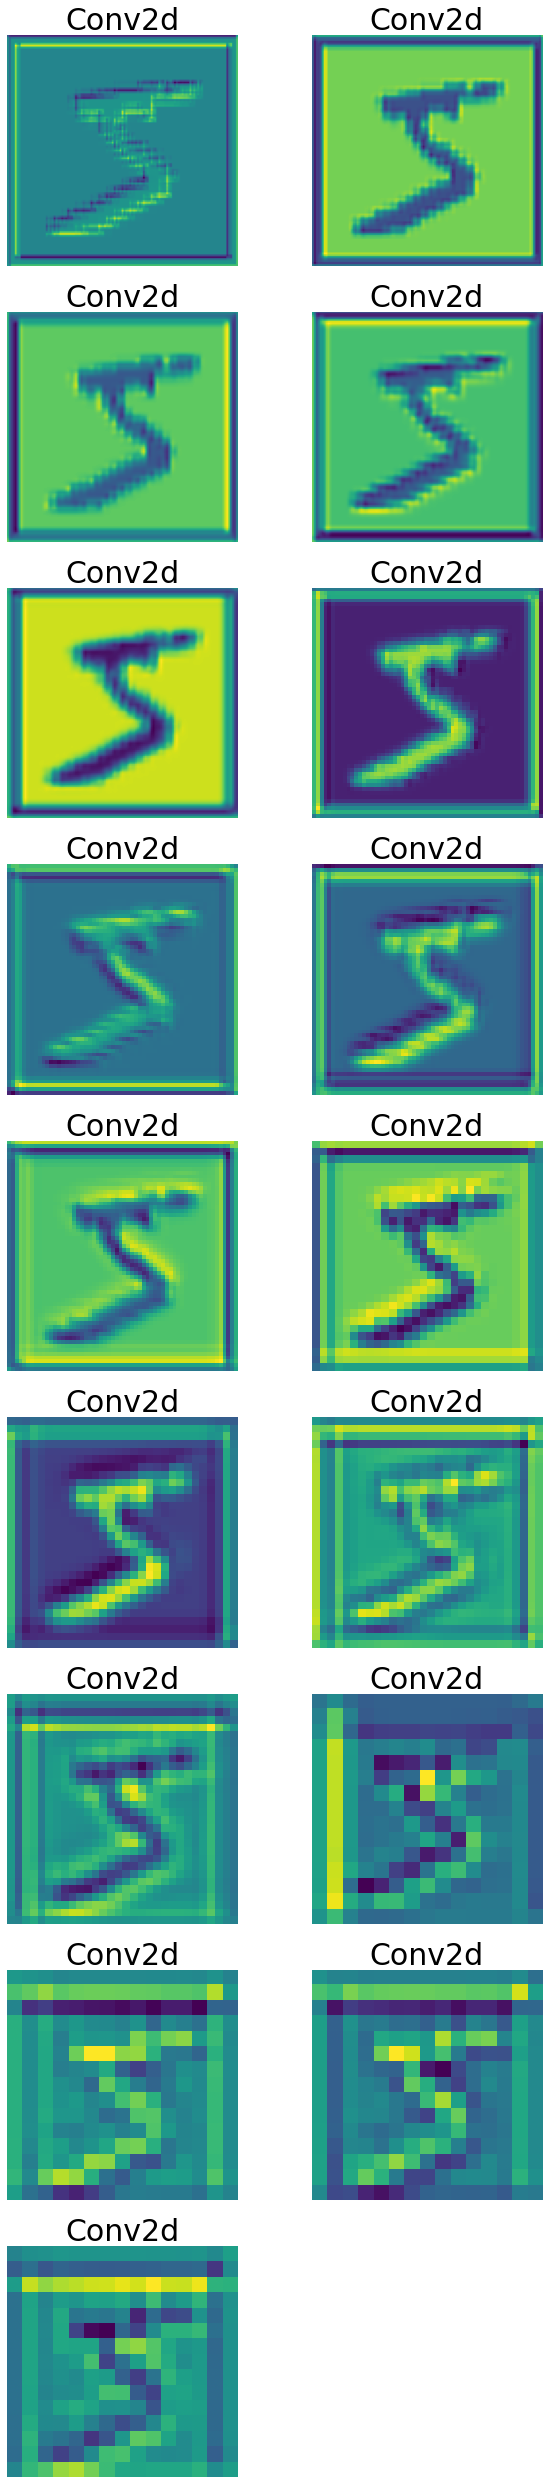

In [ ]:
# Plotting the outputs of the layers
fig = plt.figure(figsize=(10, 50))
for i in range(len(processed)):
    # Creating a subplot for each feature map
    a = fig.add_subplot(10, 2, i+1)
    # Plotting the feature map
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    # Adding the title of the feature map
    a.set_title(names[i].split('(')[0], fontsize=30)
# Saving the figure
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')


In [ ]:
import numpy as np
import seaborn as sns


17


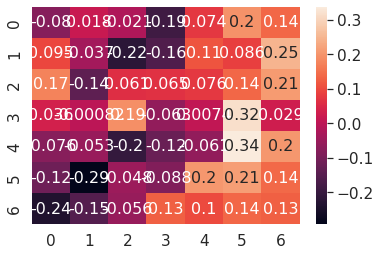

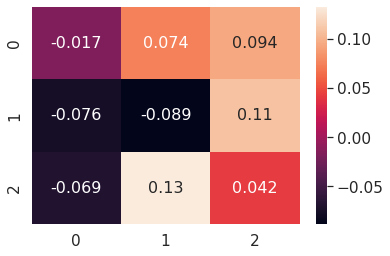

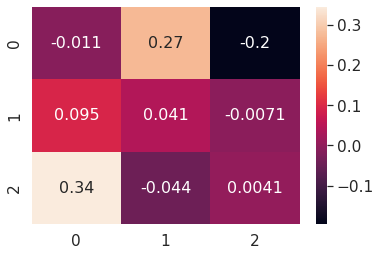

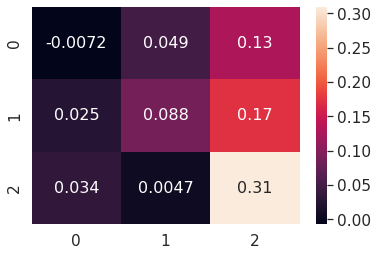

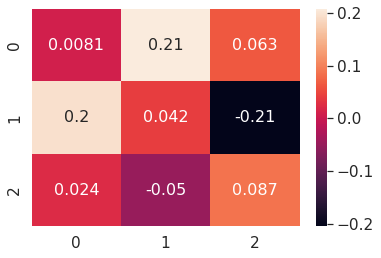

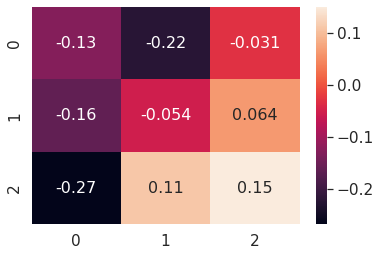

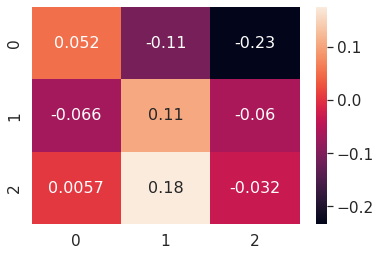

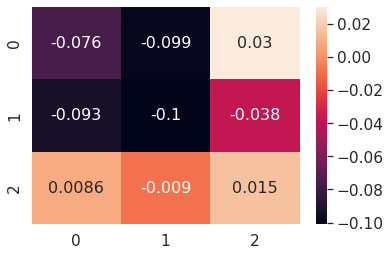

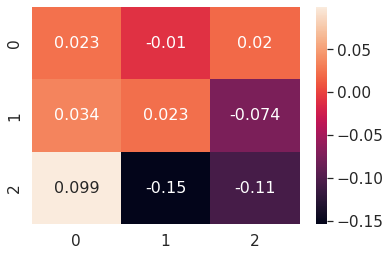

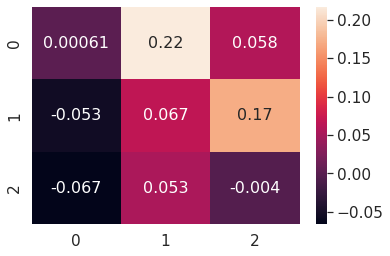

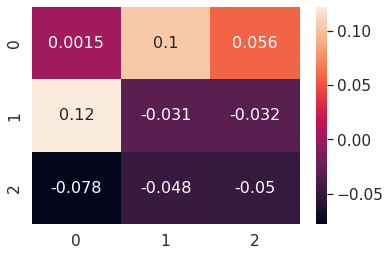

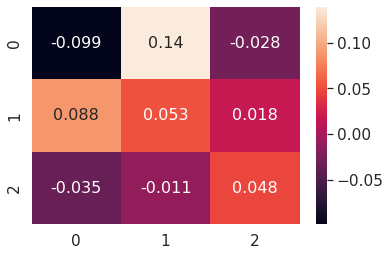

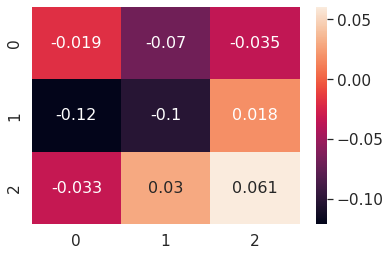

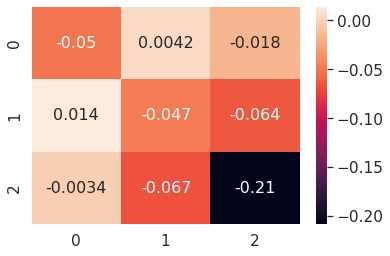

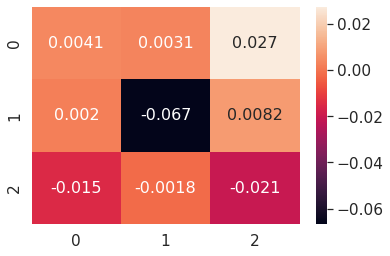

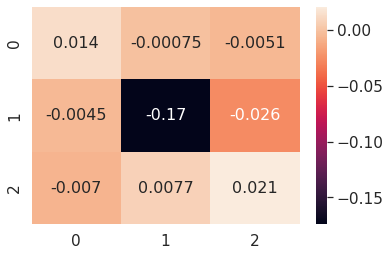

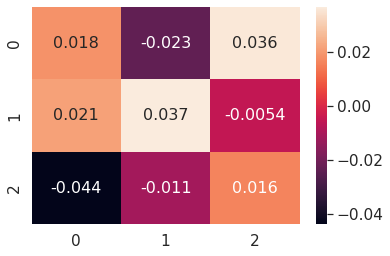

In [ ]:
# Visualizing the filters of the first conv layer
import pandas as pd
# Getting the weights of the conv layer
filters = [weight.data.detach().cpu() for weight in model_weights]
print(len(filters))
# Plotting the filters
for weight in filters:
  plt.figure()
  df_cm = pd.DataFrame(weight[0,0,:], range(int(weight[0,0,:].shape[0])), range(int(weight[17,0,:].shape[1])))
  # plt.figure(figsize=(10,7))
  sns.set(font_scale=1.4) # for label size
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
  #plt.imshow(weight[0,0,:])
plt.show()